In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import torch


In [2]:
def load_datasets(train_path = "train_data.json", test_path = "test_data.json"):
    """Load the datasets, fill in missing values and create prompt response pairs"""
    train_df = pd.read_json(train_path)
    test_df = pd.read_json(test_path)

    # filling in missing values

    train_df["user_prompt"].fillna("",inplace=True)
    train_df["response"].fillna("",inplace=True)
    test_df["user_prompt"].fillna("",inplace=True)
    test_df["response"].fillna("",inplace=True)

    # prompt response pairs

    instruction = "Retrieve the safety metric description that best classifies this conversation:\n"

    # Apply efficiently
    train_df["prompt_response"] = train_df.apply(
        lambda row: instruction + "User: " + row["user_prompt"] + "\nAssistant: " + row["response"], 
        axis=1
    )

    # Do the same for test
    test_df["prompt_response"] = test_df.apply(
        lambda row: instruction + "User: " + row["user_prompt"] + "\nAssistant: " + row["response"], 
        axis=1
    )
    return train_df, test_df




In [3]:
def generate_prompt_response_embeds(path,prompt_response_pairs):
    """ using embeddingemma for generating embeddings"""
    transformer = SentenceTransformer("google/embeddinggemma-300m", trust_remote_code=True, device = "cuda")
    embeds = transformer.encode_query(prompt_response_pairs, batch_size=32, convert_to_numpy=True, show_progress_bar=True)
    np.save(path,embeds)
    return embeds
    


In [4]:
def create_prompt_response_embeds(train_df,test_df,train_embed_path = r"embeddings/train_prompt_response_embeddings.npy", test_embed_path = r"embeddings/test_prompt_response_embeddings.npy", col = "prompt_response"):
    """ load the embeddings if available else create embeddings for prompt response pairs """
    if os.path.exists(train_embed_path):
        print("path already exists!")
        train_emb =  np.load(train_embed_path)
    else:
        query = train_df[col].values
        train_emb = generate_prompt_response_embeds(train_embed_path,query)
        
    if os.path.exists(test_embed_path):
        print("path already exists!")
        
        test_emb = np.load(test_embed_path)
    else:   
        query = test_df[col].values    
        test_emb = generate_prompt_response_embeds(test_embed_path,query)
    return train_emb, test_emb

    


In [5]:

def create_metric_name_embeds(embeds_path, metric_names_list_path, target_metric_names):
    """
    embeds_path: Path to .npy file containing embedding vectors.
    metric_names_list_path: Path to .json file containing the names corresponding to the .npy rows.
    target_metric_names: The list/series of metric names from your training Dataframe that you want embeddings for.
    """
    
    # 1. Load the pre-computed embeddings
    # Shape: (Num_Unique_Metrics, Embedding_Dim) e.g., (50, 768)
    ref_embeds = np.load(embeds_path)
    
    # 2. Load the names corresponding to those embeddings
    # .flatten() is CRITICAL here to convert [['name']] to ['name']
    ref_names = pd.read_json(metric_names_list_path).values.flatten()
    
    # 3. Create the Lookup Dictionary
    # zip is cleaner: maps name -> vector
    metric_lookup = dict(zip(ref_names, ref_embeds))
    
    # 4. Map your specific dataframe column to the embeddings
    # We use a list comprehension to fetch the vector for each row in your dataset
    ordered_embeds = [metric_lookup[name] for name in target_metric_names]
    
    # 5. Stack into a single numpy matrix
    return np.vstack(ordered_embeds)

In [6]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D # Required for 3D plotting
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances, manhattan_distances

def plot_distances(metric_emb, emb, y, transform=None):
    # 1. Calculate Diagonals 
    cossim = cosine_similarity(metric_emb, emb).diagonal()
    euc_dist = euclidean_distances(metric_emb, emb).diagonal()
    man_dist = manhattan_distances(metric_emb, emb).diagonal()

    if transform:
        cossim = transform(cossim)
        euc_dist = transform(euc_dist)
        man_dist = transform(man_dist)

    # 2. Setup Figure (2 Rows, 2 Columns)
    # We use a larger figure size to accommodate the 3D plot
    fig = plt.figure(figsize=(15, 12))

    # --- Plot 1: Cosine Similarity (Top Left) ---
    ax1 = fig.add_subplot(2, 2, 1)
    sc1 = ax1.scatter(y, cossim, alpha=0.3, c=y, cmap='viridis')
    ax1.set_title("Cosine Similarity (Higher is Better)")
    ax1.set_xlabel("Target Score")
    ax1.set_ylabel("Similarity")
    ax1.grid(True, linestyle='--', alpha=0.3)

    # --- Plot 2: Euclidean Distance (Top Right) ---
    ax2 = fig.add_subplot(2, 2, 2)
    sc2 = ax2.scatter(y, euc_dist, alpha=0.3, c=y, cmap='viridis')
    ax2.set_title("Euclidean Distance (Lower is Better)")
    ax2.set_xlabel("Target Score")
    ax2.set_ylabel("Distance")
    ax2.grid(True, linestyle='--', alpha=0.3)

    # --- Plot 3: Manhattan Distance (Bottom Left) ---
    ax3 = fig.add_subplot(2, 2, 3)
    sc3 = ax3.scatter(y, man_dist, alpha=0.3, c=y, cmap='viridis')
    ax3.set_title("Manhattan Distance (Lower is Better)")
    ax3.set_xlabel("Target Score")
    ax3.set_ylabel("Distance")
    ax3.grid(True, linestyle='--', alpha=0.3)

    # --- Plot 4: 3D Metric Space (Bottom Right) ---
    # X=Cosine, Y=Euclidean, Z=Manhattan, Color=Score
    ax4 = fig.add_subplot(2, 2, 4, projection='3d')
    
    # We invert Euclidean/Manhattan so that "Better" is always "Up/Right" visually if possible,
    # or just plot raw to see the manifold. Let's plot raw.
    sc4 = ax4.scatter(cossim, euc_dist, man_dist, c=y, cmap='viridis', alpha=0.6, s=20)
    
    ax4.set_title("3D Metric Manifold\n(Color = Score)")
    ax4.set_xlabel("Cosine Sim")
    ax4.set_ylabel("Euclidean Dist")
    ax4.set_zlabel("Manhattan Dist")
    
    # Add a colorbar to interpret the score
    cbar = plt.colorbar(sc4, ax=ax4, pad=0.1)
    cbar.set_label('Target Score (0-10)')

    plt.tight_layout()
    plt.show()

# Example Usage:
# plot_distances_3d(X_metric_train, X_prompt_train, y_train)

In [7]:
def log_transform(scores):
    return np.log1p(scores)

In [ ]:
from sklearn.decomposition import PCA
def apply_pca(embeddings):
    pca = PCA()


In [7]:
import torch.nn as nn
class Siamese_Net(nn.Module):
    def __init__(self, input_dim=768, output_dim=32, dropout=0.5):
        super(Siamese_Net, self).__init__()
        
        self.tower_layer = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.LayerNorm(256),  # Add batch normalization
            nn.Tanh(),
            nn.Dropout(dropout),
             
            nn.Linear(256, output_dim),

        )
        
        self.out = nn.Sequential(
            nn.Dropout(dropout * 0.5), 
            nn.Linear(output_dim, 16),
            nn.Tanh(),
            nn.Linear(16,1)

        )
    
    def forward(self, x1, x2):
        u = self.tower_layer(x1)
        v = self.tower_layer(x2)
        diff = torch.abs(u - v)
        y = self.out(diff)
        return y

In [ ]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter




def oversampling(X, y,shrinkage, threshold = 1000):
    """ Oversample minority classes through random sampling with shrinkage"""
    counts = Counter(y)
    sampling_strategy = {key: threshold for key, cnt in counts.items() if cnt < threshold}
    ros = RandomOverSampler(sampling_strategy=sampling_strategy, shrinkage=shrinkage)
    resampled_X, resampled_y = ros.fit_resample(X, y)
    return resampled_X, resampled_y


def undersampling(X, y, threshold=1000):
    """ Undersample majority classes that exceed threshold"""
    counts = Counter(y)
    sampling_strategy = {key: threshold for key, cnt in counts.items() if cnt > threshold }
    rus = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=42)
    resampled_X, resampled_y = rus.fit_resample(X, y)
    return resampled_X, resampled_y


def balanced_sampling(X, y, oversample_threshold=50, undersample_threshold=1500, shrinkage=0.5):
    """ 
    Apply both oversampling and undersampling for balanced dataset
    
    Args:
        X: Features
        y: Labels
        oversample_threshold: Classes with count < this will be oversampled
        undersample_threshold: Classes with count > this will be undersampled
        shrinkage: Shrinkage parameter for oversampling
    """
    print(f"Original class distribution: {Counter(y)}")
    
    # First undersample the majority classes
    X_under, y_under = undersampling(X, y, threshold=undersample_threshold)
    print(f"After undersampling: {Counter(y_under)}")
    
    # Then oversample the minority classes
    X_balanced, y_balanced = oversampling(X_under, y_under, shrinkage=shrinkage)
    print(f"After oversampling: {Counter(y_balanced)}")
    
    return X_balanced, y_balanced


In [150]:
from sklearn.utils.class_weight import compute_class_weight
def return_weights(y):
    """ Returns weights for class i through inverse class frequencies"""
    unique_classes = np.unique(y)
    weights = compute_class_weight(class_weight="balanced",classes=unique_classes,y=y)
    weights = weights**2

    return weights
     

In [151]:
y = np.array([2,2,2,1,3,3,4,5,4,5])
print(y)
print(return_weights(y))

[2 2 2 1 3 3 4 5 4 5]
[4.         0.44444444 1.         1.         1.        ]


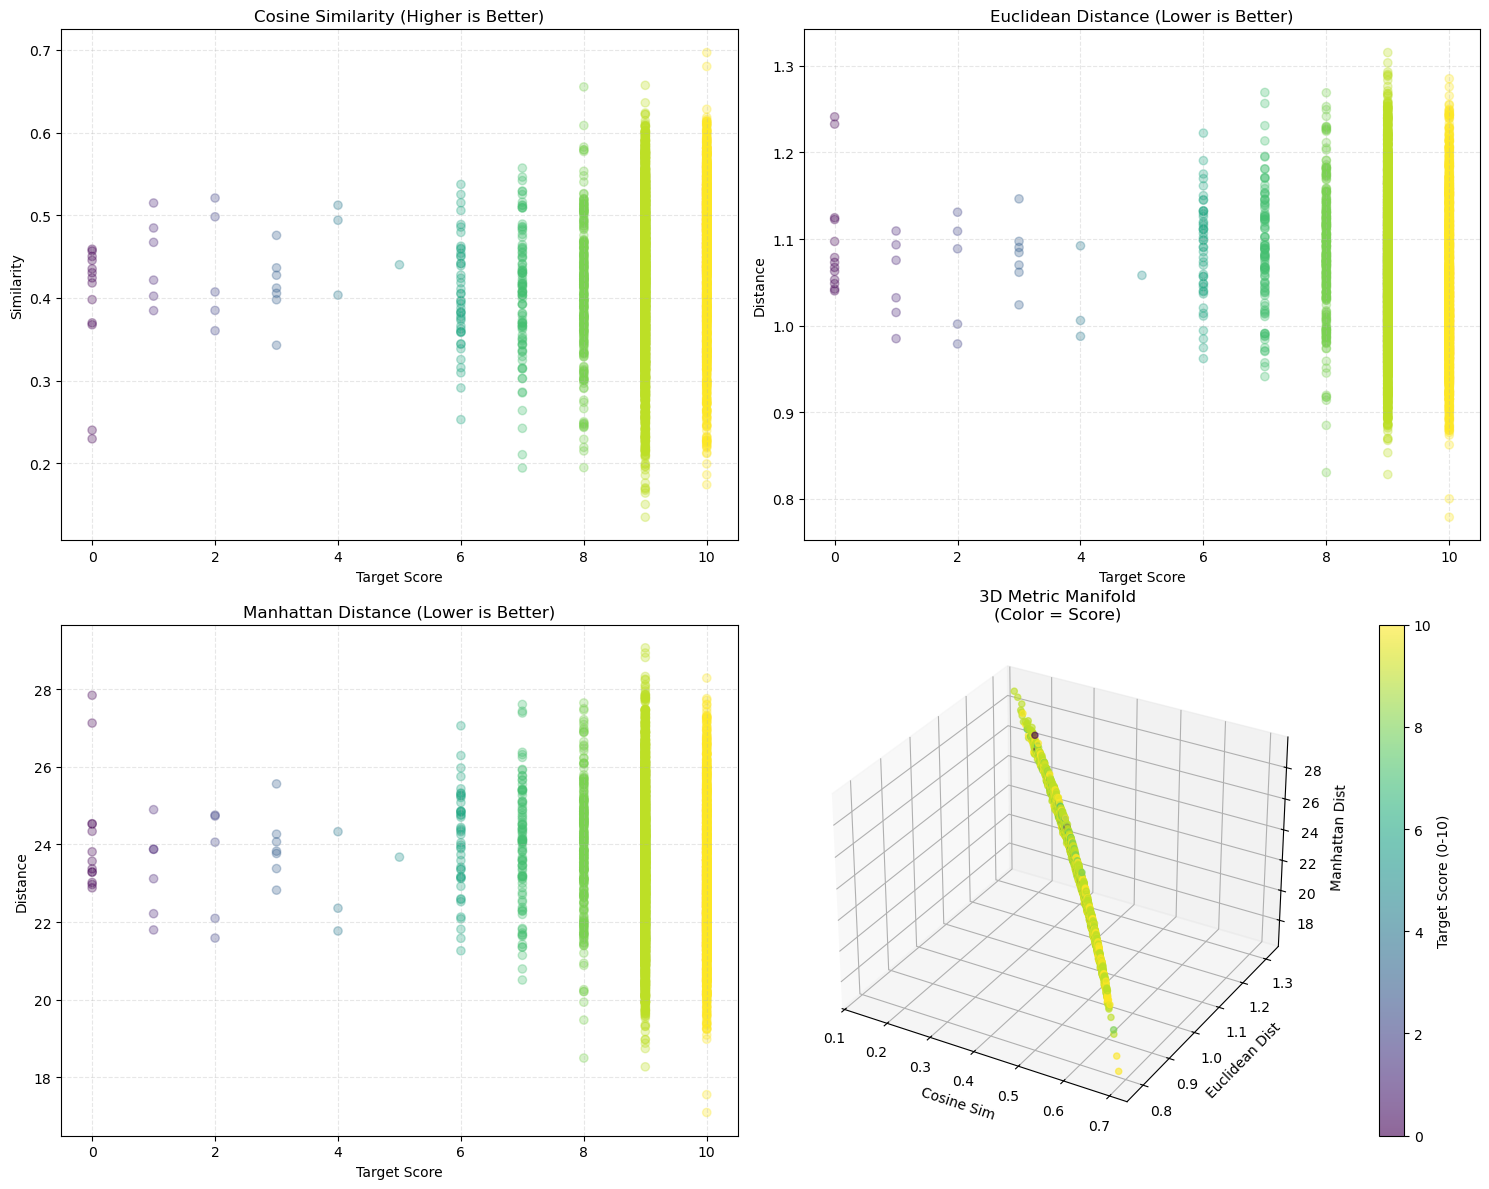

In [11]:
plot_distances(train_metric_emb,train_emb,train_labels)

In [9]:
metric_embeds_path = "metric_name_embeddings.npy"
metric_names_path = "metric_names.json"
train_df, test_df = load_datasets()
train_emb,test_emb = create_prompt_response_embeds(train_df,test_df,r"embeddings/train_prompt_response_system_embeddings.npy",r"embeddings/test_prompt_response_system_embeddings.npy")
target_metric_names_train = train_df["metric_name"].to_list()
target_metric_names_test = test_df["metric_name"].to_list()
train_metric_emb = create_metric_name_embeds(metric_embeds_path,metric_names_path,target_metric_names_train)
test_metric_emb = create_metric_name_embeds(metric_embeds_path,metric_names_path,target_metric_names_test)
train_labels = train_df["score"].values.astype("int")



path already exists!
path already exists!


C:\Users\siddh\AppData\Local\Temp\ipykernel_14188\2157456695.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df["user_prompt"].fillna("",inplace=True)
C:\Users\siddh\AppData\Local\Temp\ipykernel_14188\2157456695.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exam

In [8]:


class WeightedMSELoss(nn.Module):
    """
    Weighted Mean Squared Error Loss
    
    Applies class weights to MSE loss for handling class imbalance in regression tasks
    or applying different importance to different samples/classes.
    """
    
    def __init__(self, weights=None,target_offset = 0):
        """
        Args:
            weights: Tensor of shape (num_classes,) or (num_samples,) containing weights
                     If None, uses uniform weights (equivalent to standard MSE)
        """
        super(WeightedMSELoss, self).__init__()
        self.weights = weights
        self.target_offset = target_offset
    def forward(self, predictions, targets):
        """
        Args:
            predictions: Predicted values, shape (batch_size,) or (batch_size, num_outputs)
            targets: Ground truth values, same shape as predictions
            
        Returns:
            Weighted MSE loss (scalar)
        """
        # Calculate squared error
        squared_error = (predictions - targets) ** 2
        
        if self.weights is not None:
            # Ensure weights are on the same device as predictions
            weights = self.weights.to(predictions.device)
            
            # Flatten targets if needed
            target_indices = targets.flatten().long()
            
            # Apply offset (subtract 1 if targets are 1-10)
            if self.target_offset > 0:
                target_indices = target_indices - self.target_offset
            
            # Map targets to weights
            sample_weights = weights[target_indices]
            
            # Reshape sample_weights to match squared_error shape
            if len(squared_error.shape) > 1:
                sample_weights = sample_weights.unsqueeze(-1)
            
            weighted_se = squared_error * sample_weights
            return weighted_se.mean()
        else:
            # Standard MSE if no weights provided
            return squared_error.mean()


# Alternative: Per-sample weighted MSE
class SampleWeightedMSELoss(nn.Module):
    """
    Weighted MSE Loss where each sample has its own weight
    """
    
    def __init__(self):
        super(SampleWeightedMSELoss, self).__init__()
        
    def forward(self, predictions, targets, sample_weights):
        """
        Args:
            predictions: Predicted values, shape (batch_size,) or (batch_size, num_outputs)
            targets: Ground truth values, same shape as predictions
            sample_weights: Weight for each sample, shape (batch_size,)
            
        Returns:
            Weighted MSE loss (scalar)
        """
        squared_error = (predictions - targets) ** 2
        
        # Expand sample_weights if needed
        if len(squared_error.shape) > 1 and len(sample_weights.shape) == 1:
            sample_weights = sample_weights.unsqueeze(-1)
        
        weighted_se = squared_error * sample_weights
        return weighted_se.sum() / sample_weights.sum()


# Usage examples:

# Example 1: Using class weights (for classification-style weighting)
"""
# Assuming you have class_weights_tensor from earlier
criterion = WeightedMSELoss(weights=class_weights_tensor)

# In training loop
outputs = model(features)
loss = criterion(outputs, targets)  # targets should be class indices
"""

# Example 2: Direct element-wise weights
"""
# Create custom weights for each class/output
weights = torch.tensor([1.0, 2.0, 1.5, 3.0])  # Weight for each class
criterion = WeightedMSELoss(weights=weights)

# In training loop
outputs = model(features)
loss = criterion(outputs, targets)
"""

# Example 3: Per-sample weighting
"""
criterion = SampleWeightedMSELoss()

# In training loop
outputs = model(features)
sample_weights = torch.ones(outputs.size(0))  # Or compute based on your logic
loss = criterion(outputs, targets, sample_weights)
"""

# Example 4: Integration with your training loop
"""
import torch.optim as optim

# Define model and weighted loss
model = YourModel()
criterion = WeightedMSELoss(weights=class_weights_tensor)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train
history = train_loop(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    epochs=100,
    device='cuda'
)
"""

"\nimport torch.optim as optim\n\n# Define model and weighted loss\nmodel = YourModel()\ncriterion = WeightedMSELoss(weights=class_weights_tensor)\noptimizer = optim.Adam(model.parameters(), lr=0.001)\n\n# Train\nhistory = train_loop(\n    model=model,\n    train_loader=train_loader,\n    val_loader=val_loader,\n    optimizer=optimizer,\n    criterion=criterion,\n    epochs=100,\n    device='cuda'\n)\n"

(5000, 256)

In [173]:
from torch.utils.data import TensorDataset, DataLoader

Train_dataset = np.hstack((train_emb[:,:128], train_metric_emb[:,:128]))
Test_dataset = np.hstack((test_emb[:,:128], test_metric_emb[:,:128]))

# Assuming you have labels only for train
train_labels = train_labels  # Your numpy array of train labels

# First, split train into train and validation (80-20 split)
train_size = int(0.8 * len(Train_dataset))
val_size = len(Train_dataset) - train_size

# Create indices for splitting
indices = np.arange(len(Train_dataset))
np.random.seed(42)  # For reproducibility
np.random.shuffle(indices)

train_indices = indices[:train_size]
val_indices = indices[train_size:]

# Split the data
X_train = Train_dataset[train_indices]
y_train = train_labels[train_indices]
X_val = Train_dataset[val_indices]
y_val = train_labels[val_indices]

print(f"Before oversampling - Train: {len(X_train)}, Val: {len(X_val)}")

# Apply oversampling ONLY to train set
X_train_resampled, y_train_resampled = balanced_sampling(
    X_train, 
    y_train, 
    shrinkage=0.5,
      # Adjust as needed
)

# Compute class weights from resampled training labels
class_weights = return_weights(y_train_resampled)
class_weights_tensor = torch.FloatTensor(class_weights)

print(f"After oversampling - Train: {len(X_train_resampled)}, Val: {len(X_val)}")
print(f"Class weights: {class_weights}")

# Convert to PyTorch tensors
Train_tensor = torch.FloatTensor(X_train_resampled)
Train_labels_tensor = torch.LongTensor(y_train_resampled)
Val_tensor = torch.FloatTensor(X_val)
Val_labels_tensor = torch.LongTensor(y_val)
Test_tensor = torch.FloatTensor(Test_dataset)

# Create TensorDatasets
train_dataset = TensorDataset(Train_tensor, Train_labels_tensor)
val_dataset = TensorDataset(Val_tensor, Val_labels_tensor)
test_dataset = TensorDataset(Test_tensor)  # No labels for test

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Final - Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")

# Use class_weights_tensor in your loss function
# Example: criterion = torch.nn.CrossEntropyLoss(weight=class_weights_tensor)

Before oversampling - Train: 4000, Val: 1000
Original class distribution: Counter({9: 2507, 10: 1149, 8: 205, 7: 78, 6: 36, 0: 10, 3: 4, 2: 4, 1: 4, 4: 2, 5: 1})
After undersampling: Counter({9: 500, 10: 500, 8: 205, 7: 78, 6: 36, 0: 10, 1: 4, 2: 4, 3: 4, 4: 2, 5: 1})
After oversampling: Counter({0: 1000, 1: 1000, 2: 1000, 3: 1000, 4: 1000, 5: 1000, 6: 1000, 7: 1000, 9: 500, 10: 500, 8: 205})
After oversampling - Train: 9205, Val: 1000
Class weights: [ 0.70026467  0.70026467  0.70026467  0.70026467  0.70026467  0.70026467
  0.70026467  0.70026467 16.66304984  2.80105868  2.80105868]
Final - Train: 9205, Val: 1000, Test: 3638


In [39]:
a,b = next(iter(train_loader))
b

tensor([ 7,  9,  7,  9, 10,  9,  7,  9, 10,  6, 10,  9,  7,  9,  9, 10,  9,  9,
         9, 10,  9,  9,  6,  9,  6,  9,  8,  6,  6,  7,  9,  9])

In [174]:
def train_loop(model, train_loader, val_loader, optimizer, criterion, epochs=150, device='cuda'):
    """Training loop for Siamese Network with weighted train loss and unweighted val loss"""
    
    model = model.to(device)
    val_criterion = nn.MSELoss()  # Unweighted MSE for validation
    
    history = {'train_loss': [], 'val_loss': []}
    best_val_loss = float('inf')
    
    for epoch in range(epochs):
        # ================== Training Phase ==================
        model.train()
        train_loss = 0.0
        
        for features, labels in train_loader:
            # Split features into two inputs
            emb_dim = features.shape[1] // 2
            x1 = features[:, :emb_dim].to(device)
            x2 = features[:, emb_dim:].to(device)
            #features = features.to(device)
            labels = labels.to(device).float().unsqueeze(1)
            
            # Forward pass
            optimizer.zero_grad()
            output = model(x1,x2)
            loss = criterion(output, labels)  # Weighted loss for training
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        avg_train_loss = train_loss / len(train_loader)
        
        # ================== Validation Phase ==================
        model.eval()
        val_loss = 0.0
        
        with torch.no_grad():
            for features, labels in val_loader:
                emb_dim = features.shape[1] // 2
                x1 = features[:, :emb_dim].to(device)
                x2 = features[:, emb_dim:].to(device)
               # features = features.to(device)
                labels = labels.to(device).float().unsqueeze(1)
                
                output = model(x1,x2)
                loss = val_criterion(output, labels)  # Unweighted MSE for validation
                val_loss += loss.item()
        
        avg_val_loss = val_loss / len(val_loader)
        
        # Store history
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        
        # Print progress
        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f'Epoch [{epoch+1}/{epochs}] - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')
        
        # Save best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), 'best_siamese_model.pth')
    
    print(f'Training completed! Best Val Loss: {best_val_loss:.4f}')
    return history

In [175]:

model = Siamese_Net(input_dim=128, output_dim=32)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Weighted loss for training
#criterion = WeightedMSELoss(weights=class_weights_tensor)
criterion = nn.MSELoss()
# or for standard weighted MSE:
# criterion = nn.MSELoss()  # if you want unweighted for both

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

history = train_loop(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,  # This can be weighted
    epochs=150,
    device=device
)

Epoch [1/150] - Train Loss: 10.0341, Val Loss: 24.3881
Epoch [10/150] - Train Loss: 1.4077, Val Loss: 3.8454
Epoch [20/150] - Train Loss: 1.0348, Val Loss: 3.0971
Epoch [30/150] - Train Loss: 0.8207, Val Loss: 3.6535
Epoch [40/150] - Train Loss: 0.7114, Val Loss: 3.3481
Epoch [50/150] - Train Loss: 0.7024, Val Loss: 2.9378
Epoch [60/150] - Train Loss: 0.6262, Val Loss: 2.8121
Epoch [70/150] - Train Loss: 0.6648, Val Loss: 2.4694
Epoch [80/150] - Train Loss: 0.5786, Val Loss: 2.2892
Epoch [90/150] - Train Loss: 0.5937, Val Loss: 1.9841
Epoch [100/150] - Train Loss: 0.5547, Val Loss: 2.1438
Epoch [110/150] - Train Loss: 0.5326, Val Loss: 2.1107
Epoch [120/150] - Train Loss: 0.5413, Val Loss: 2.1959
Epoch [130/150] - Train Loss: 0.5004, Val Loss: 2.9052
Epoch [140/150] - Train Loss: 0.5032, Val Loss: 2.1964
Epoch [150/150] - Train Loss: 0.5240, Val Loss: 2.0734
Training completed! Best Val Loss: 1.7988


In [178]:
import torch
import pandas as pd
import numpy as np

def make_predictions(model, test_loader, device='cuda'):
    """Make predictions on test set"""
    
    model = model.to(device)
    model.eval()
    
    y_preds = []
    
    with torch.no_grad():
        for batch in test_loader:
            features = batch[0]  # Extract features from batch
            
            # Split features into two inputs
            emb_dim = features.shape[1] // 2
            x1 = features[:, :emb_dim].to(device)
            x2 = features[:, emb_dim:].to(device)
            #features = features.to(device)
            
            # Forward pass
            output = model(x1,x2)
            
            # Store predictions
            y_preds.extend(output.squeeze().cpu().numpy())
    
    # Convert to numpy array and round
    y_preds = np.array(y_preds)
    y_preds_rounded = np.round(y_preds)
    
    return y_preds_rounded


# Make predictions
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load best model (optional, if you want to use the saved best model)
model.load_state_dict(torch.load('best_siamese_model.pth'))

y_preds = make_predictions(model, test_loader, device=device)

# Create Kaggle-style submission DataFrame
submission_df = pd.DataFrame({
    'id': range(1,len(y_preds)+1),  # Or use your actual test IDs if you have them
    'score': y_preds
})

# Export to CSV
submission_df.to_csv('submission_nn_maybe_not_.csv', index=False)

print(f"Predictions saved! Total predictions: {len(y_preds)}")
print(submission_df.head())

C:\Users\siddh\AppData\Local\Temp\ipykernel_11724\3447122295.py:40: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_siamese_model.pth'))

Predictions saved! Total predictions: 3638
   id  score
0   1    9.0
1   2    7.0
2   3    7.0
3   4    9.0
4   5    9.0


<Axes: ylabel='Frequency'>

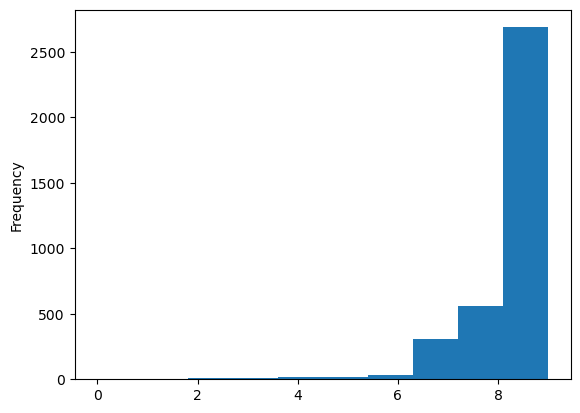

In [177]:
submission_df["score"].plot.hist()